In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import nilearn.image, nilearn.masking
from nilearn import plotting as nplt
import statsmodels.stats.multitest

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
# from PCRegression import PCR
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937
today = date.today().strftime("%Y%m%d")

In [4]:
root_dir = '/Volumes/T7SSD1/GA'

In [5]:
id_list = ['GA', 'GB']
nn_list = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
           '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
           '31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
run_list = ['r01', 'r02', 'r03', 'r04', 'r05', 'r06']

In [50]:
fMRI_dir = root_dir + '/fMRI_data'
preproc_dir = fMRI_dir + '/preproc_data'
stat_dir = fMRI_dir + '/stats'
roi_dir = fMRI_dir + '/roi'
loc_dir = roi_dir + '/localizer'
dmn_dir = roi_dir + '/DMN'
# roi_full_dir = roi_dir + '/full'                # tlrc
# roi_caudate_dir = roi_dir + '/GA_caudate_roi'   # orig
# roi_split_dir = roi_dir + '/split_roi'          # orig
# roi_caudate_fin_dir = roi_caudate_dir + '/slicer_2/tlrc_resam_fullmask' # MNI
data_dir = preproc_dir

In [7]:
def fast_masking(img, roi):
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T

In [8]:
## LDA analysis
def accuracy(train_X, train_y, test_X, test_y):
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda.fit(train_X, train_y)
    
    return np.mean(lda.predict(test_X) == test_y)

def cross_validation(datasets, target):
    train_y = target + target
    test_y = target
    
    result = []
    
    for i in range(len(datasets)):
        train_X = np.concatenate([a for j, a in enumerate(datasets) if j != i])
        test_X = datasets[i]
        
        result.append(accuracy(train_X, train_y, test_X, test_y))
        
    return np.mean(result)

### Movement-related ROIs

In [45]:
roi_path = sorted(glob(loc_dir + '/n200_*.nii'))
roi_imgs = {}

for path in roi_path:
    roi_imgs[path.split('/')[-1].replace('_mask.nii', '')] = (nilearn.image.load_img(path))
    
roi_names = sorted(roi_imgs.keys())
roi_names

['n200_c1-1_L_M1',
 'n200_c1-2_L_S1',
 'n200_c1_L_Postcentral',
 'n200_c1_R_SPL',
 'n200_c2_R_CerebellumIV-V',
 'n200_c2_R_MFG',
 'n200_c3_R_MTG',
 'n200_c3_R_Postcentral',
 'n200_c4_L_IFG',
 'n200_c4_L_Putamen',
 'n200_c5_L_SPL',
 'n200_c5_R_SMA',
 'n200_c6_R_CerebellumVIIIb',
 'n200_c6_R_MFG',
 'n200_c7_L_Thalamus',
 'n200_c7_R_MFG2',
 'n200_c8_R_IFG',
 'n200_c9_L_MTG']

### Localizer ROIs

In [47]:
roi_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7f8fb2966970>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7f8fc244fac0>,
 'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7f8fc2445910>,
 'n200_c1_R_SPL': <nibabel.nifti1.Nifti1Image at 0x7f8fc2445580>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7f8fc2213e80>,
 'n200_c2_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7f8fb295b5b0>,
 'n200_c3_R_MTG': <nibabel.nifti1.Nifti1Image at 0x7f8fb276f7c0>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7f8fb276f370>,
 'n200_c4_L_IFG': <nibabel.nifti1.Nifti1Image at 0x7f8fb276ff70>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7f8fb2774cd0>,
 'n200_c5_L_SPL': <nibabel.nifti1.Nifti1Image at 0x7f8fb2774f10>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7f8fb2875520>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7f8fb28750d0>,
 'n200_c6_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7f8fb2875b50>,
 'n200_c7_L_Thalamus': <nibabel

## MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

### Loading $\beta$s

In [11]:
## load betas
data = {}

for ii in id_list:
    for nn in nn_list:
        subj = ii + nn
        for run in run_list:
            data[subj, run] = nilearn.image.load_img(join(data_dir,nn,'betasLSS.%s.%s.nii.gz'%(subj,run)))
        print(subj, end='\r')

In [12]:
## indexing
for key, value in data.items():
    data[key] = nilearn.image.index_img(value, np.arange(1, 97))

In [13]:
## labeling target position
target_pos = []

with open(join(root_dir,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
target_path = list(range(1,13))*8

### MVPA result, and saving it to .pkl

In [14]:
results = {}

for ii in id_list:
    for nn in nn_list:
        subj = ii + nn
        for name, roi_img in roi_imgs.items():
            for i, pp in enumerate(['practiced','unpracticed']):
                X = [fast_masking(roi=roi_img, img=data[subj,rr]) for rr in run_list[i*3:(i+1)*3]]
                results['pos', pp, subj, name] = cross_validation(X, target_pos)
            print(subj, name, end='\r')

In [15]:
results

{('pos', 'practiced', 'GA01', 'n200_c1-1_L_M1'): 0.3680555555555556,
 ('pos', 'unpracticed', 'GA01', 'n200_c1-1_L_M1'): 0.31597222222222227,
 ('pos', 'practiced', 'GA01', 'n200_c1-2_L_S1'): 0.3576388888888889,
 ('pos', 'unpracticed', 'GA01', 'n200_c1-2_L_S1'): 0.4201388888888889,
 ('pos', 'practiced', 'GA01', 'n200_c1_L_Postcentral'): 0.37847222222222227,
 ('pos', 'unpracticed', 'GA01', 'n200_c1_L_Postcentral'): 0.4131944444444444,
 ('pos', 'practiced', 'GA01', 'n200_c1_R_SPL'): 0.38888888888888884,
 ('pos', 'unpracticed', 'GA01', 'n200_c1_R_SPL'): 0.3333333333333333,
 ('pos', 'practiced', 'GA01', 'n200_c2_R_CerebellumIV-V'): 0.2604166666666667,
 ('pos',
  'unpracticed',
  'GA01',
  'n200_c2_R_CerebellumIV-V'): 0.31597222222222227,
 ('pos', 'practiced', 'GA01', 'n200_c2_R_MFG'): 0.2951388888888889,
 ('pos', 'unpracticed', 'GA01', 'n200_c2_R_MFG'): 0.3368055555555555,
 ('pos', 'practiced', 'GA01', 'n200_c3_R_MTG'): 0.28125,
 ('pos', 'unpracticed', 'GA01', 'n200_c3_R_MTG'): 0.23611111111

In [16]:
## Save pickle
with open(today+'_results.pkl',"wb") as fw:
    pickle.dump(results, fw)

### Loading the above result .pkl

In [17]:
pkl_list = glob('*_results.pkl')
pkl_list

['20201228_results.pkl', '20201223_results.pkl']

In [35]:
## Load pickle
with open(pkl_list[0],"rb") as fr:
    results = pickle.load(file=fr)
# print(results)

In [42]:
# ## Compare
# with open(pkl_list[-1],"rb") as fr:
#     temp = pickle.load(file=fr)
# results == temp

True

### Summarizing the results to DataFrame

In [43]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for ii in id_list:
    ss = 'Early' if ii == 'GA' else 'Late'
    for nn in nn_list:
        subj = ii + nn
        for roi_name in roi_names:
            for pp in ['unpracticed', 'practiced']:
                wit_df = wit_df.append(
                    {'subj': subj
                     ,'roi_name': roi_name
                     ,'Mapping': pp
                     ,'Mean Accuracy': np.mean(results['pos', pp, subj, roi_name])
                     ,'Stage': ss}
                    , ignore_index=True)

In [44]:
wit_df

,subj,roi_name,Mapping,Mean Accuracy,Stage
0,GA01,n200_c1-1_L_M1,unpracticed,0.315972,Early
1,GA01,n200_c1-1_L_M1,practiced,0.368056,Early
2,GA01,n200_c1-2_L_S1,unpracticed,0.420139,Early
3,GA01,n200_c1-2_L_S1,practiced,0.357639,Early
4,GA01,n200_c1_L_Postcentral,unpracticed,0.413194,Early
...,...,...,...,...,...
2155,GB44,n200_c7_R_MFG2,practiced,0.270833,Late
2156,GB44,n200_c8_R_IFG,unpracticed,0.329861,Late
2157,GB44,n200_c8_R_IFG,practiced,0.291667,Late
2158,GB44,n200_c9_L_MTG,unpracticed,0.225694,Late


### t-test

In [21]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Mapping'] == 'practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

       n200_c1-1_L_M1  True 0.00 -3.96 0.000
       n200_c1-2_L_S1  True 0.00 -4.11 0.000
n200_c1_L_Postcentral  True 0.00 -4.57 0.000


In [22]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

       n200_c1-1_L_M1 False 0.11  2.52 0.018
       n200_c1-2_L_S1  True 0.03  3.15 0.004
n200_c1_L_Postcentral  True 0.03  3.15 0.004
        n200_c3_R_MTG False 0.21 -2.09 0.046


### Drawing figures

In [23]:
sns.set(style="ticks", context='talk')
palette = ['#D9D9D9', '#F23A29']

def draw_lineplot(roi_name, title):
    plt.figure(figsize=(8, 8))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.5)
    plt.ylabel('Decoding accuracy')
    #plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

n200_c1-1_L_M1


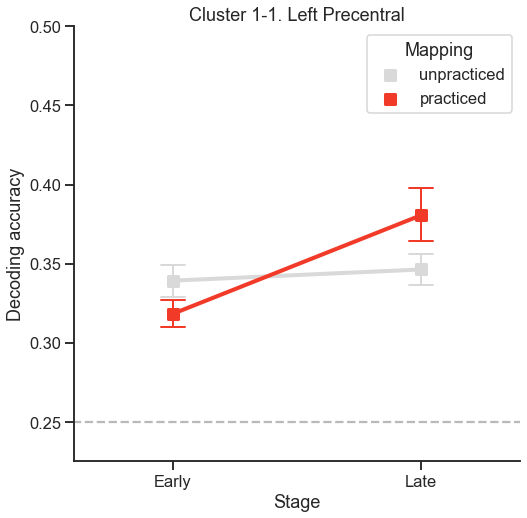

In [24]:
rname = roi_names[0]
print(rname)
draw_lineplot(rname, 'Cluster 1-1. Left Precentral')

n200_c1-2_L_S1


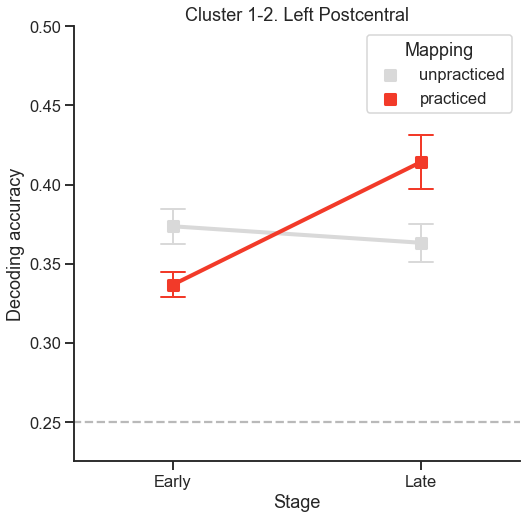

In [25]:
rname = roi_names[1]
print(rname)
draw_lineplot(rname, 'Cluster 1-2. Left Postcentral')

n200_c1_L_Postcentral


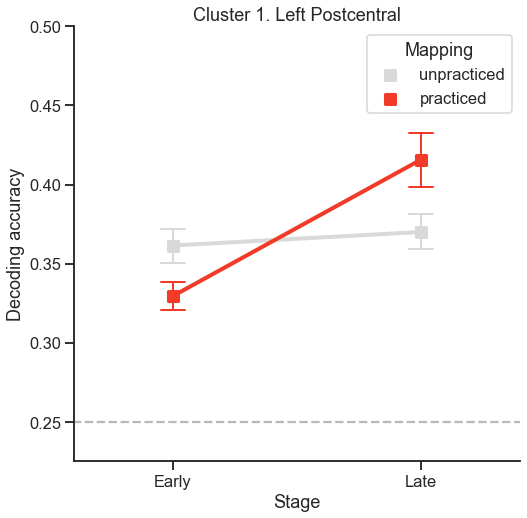

In [41]:
rname = roi_names[2]
print(rname)
draw_lineplot(rname, 'Cluster 1. Left Postcentral')

n200_c2_R_CerebellumIV-V


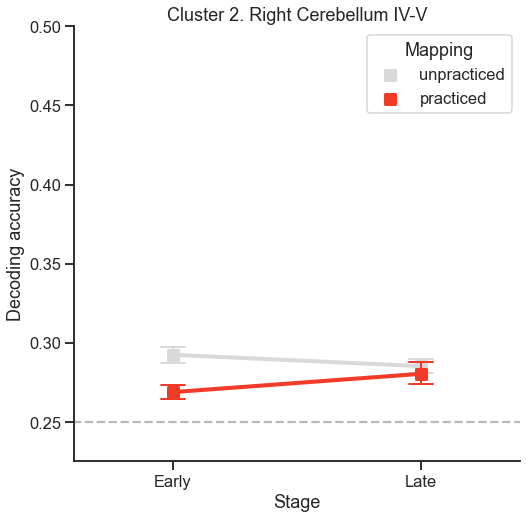

In [42]:
rname = roi_names[4]
print(rname)
draw_lineplot(rname, 'Cluster 2. Right Cerebellum IV-V')

n200_c3_R_Postcentral


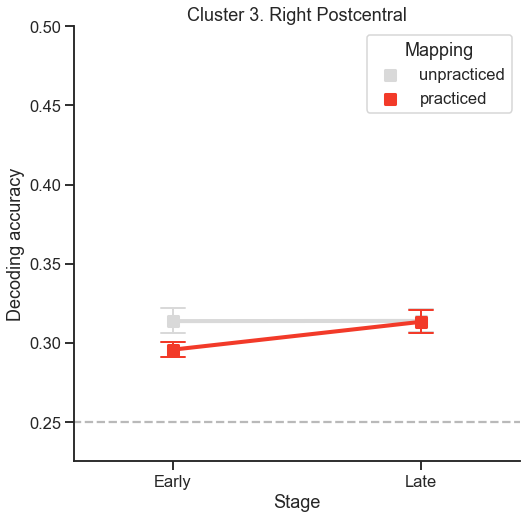

In [43]:
rname = roi_names[7]
print(rname)
draw_lineplot(rname, 'Cluster 3. Right Postcentral')

n200_c4_L_Putamen


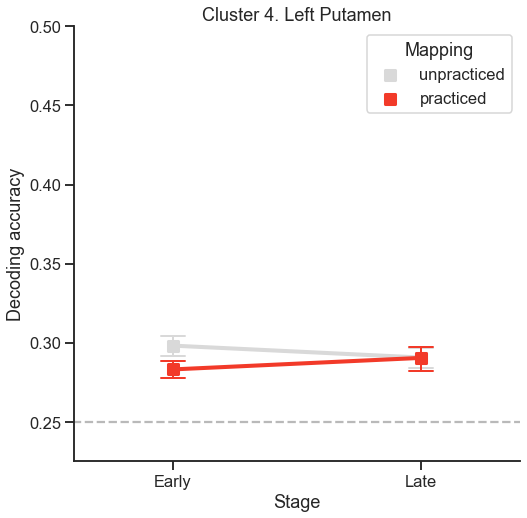

In [44]:
rname = roi_names[9]
print(rname)
draw_lineplot(rname, 'Cluster 4. Left Putamen')

n200_c5_R_SMA


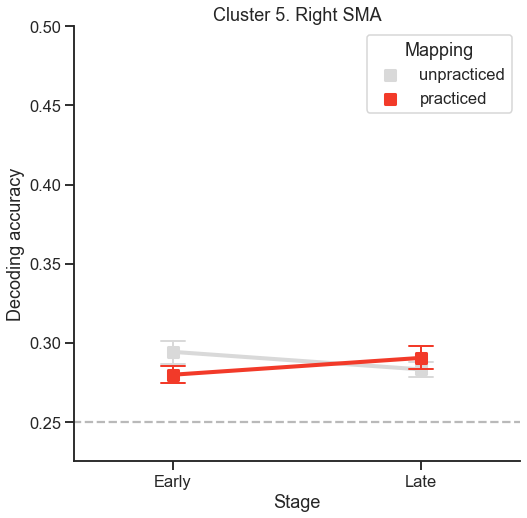

In [45]:
rname = roi_names[11]
print(rname)
draw_lineplot(rname, 'Cluster 5. Right SMA')

n200_c6_R_CerebellumVIIIb


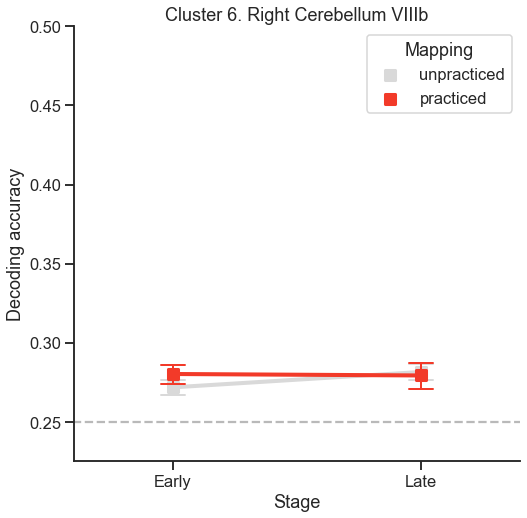

In [46]:
rname = roi_names[12]
print(rname)
draw_lineplot(rname, 'Cluster 6. Right Cerebellum VIIIb')

n200_c7_L_Thalamus


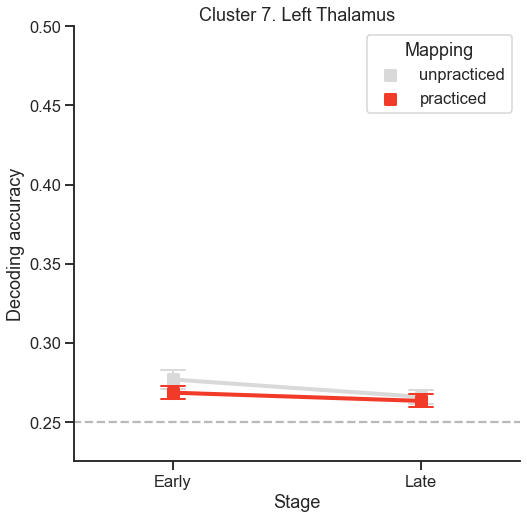

In [47]:
rname = roi_names[14]
print(rname)
draw_lineplot(rname, 'Cluster 7. Left Thalamus')

### Default Mode Network

In [52]:
module_names = ['Core', 'dMsub', 'MTLsub']

roi_imgs = []
roi_names = []

for name in module_names:
    fname = join(dmn_dir, name+'.nii')
    roi_imgs.append(nilearn.image.load_img(fname))
    roi_names.append(name)

In [56]:
roi_imgs

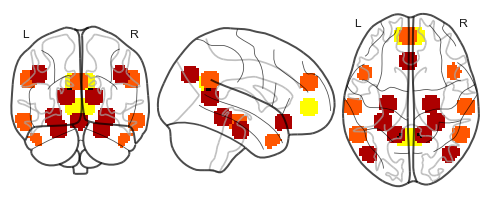

In [54]:
dmn_roi_img = nilearn.image.math_img(img1=roi_imgs[0], formula='img1 * 0')

for i, roi_img in enumerate(roi_imgs, 1):
    dmn_roi_img = nilearn.image.math_img(img1=dmn_roi_img, img2=roi_img, formula='img1 + img2 * %d' % i)
    
_ = nilearn.plotting.plot_glass_brain(dmn_roi_img)

In [58]:
results = {}

for ii in id_list:
    for nn in nn_list:
        subj = ii + nn
        for roi_img, roi_name in zip(roi_imgs, roi_names):
            for i, pp in enumerate(['practiced','unpracticed']):
                X = [fast_masking(roi=roi_img, img=data[subj,rr]) for rr in run_list[i*3:(i+1)*3]]
                results['pos', pp, subj, roi_name] = cross_validation(X, target_pos)
            print(subj, name, end='\r')

In [59]:
## Save pickle
with open(today+'_dmn_module_dec-acc.pkl',"wb") as fw:
    pickle.dump(results, fw)

In [71]:
pkl_list = glob('*_dmn_module_dec-acc.pkl')
pkl_list

['20201228_dmn_module_dec-acc.pkl',
 'mybetaLSS_20200317_dmn_module_dec-acc.pkl']

In [76]:
## Load pickle
with open(pkl_list[0],"rb") as fr:
    results = pickle.load(file=fr)

In [77]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for ii in id_list:
    ss = 'Early' if ii == 'GA' else 'Late'
    for nn in nn_list:
        subj = ii + nn
        for roi_name in roi_names:
            for pp in ['unpracticed', 'practiced']:
                wit_df = wit_df.append(
                    {'subj': subj
                     ,'roi_name': roi_name
                     ,'Mapping': pp
                     ,'Mean Accuracy': np.mean(results['pos', pp, subj, roi_name])
                     ,'Stage': ss}
                    , ignore_index=True)

In [78]:
wit_df

,subj,roi_name,Mapping,Mean Accuracy,Stage
0,GA01,Core,unpracticed,0.305556,Early
1,GA01,Core,practiced,0.350694,Early
2,GA01,dMsub,unpracticed,0.281250,Early
3,GA01,dMsub,practiced,0.333333,Early
4,GA01,MTLsub,unpracticed,0.295139,Early
...,...,...,...,...,...
355,GB44,Core,practiced,0.309028,Late
356,GB44,dMsub,unpracticed,0.277778,Late
357,GB44,dMsub,practiced,0.263889,Late
358,GB44,MTLsub,unpracticed,0.468750,Late
